# Kopp et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Kopp et al (2021) dataset.
***

In [43]:
# General imports
import os
import sys
import glob
import torch
import numpy as np
import torch.nn.functional as F

# EUGENe imports and settings
import eugene as eu
from eugene import preprocess as pp
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/kopp21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/kopp21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/"
settings.logging_dir = "/cellar/users/dlaub/projects/ML4GLand/EUGENe_paper/logs/kopp21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/kopp21"

# EUGENe packages
import seqdata as sd
import motifdata as md
import seqpro as sp

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"PyTorch version: {torch.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Eugene version: 0.0.8
SeqData version: 0.0.1
PyTorch version: 2.0.0


# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [2]:
# Read in the predictions 
sdata_test = sd.open_zarr(os.path.join(settings.output_dir, "test_predictions.zarr")).load()

# Load the best model

In [4]:
model_type = "cnn"
trial = 1

In [10]:
model_file = glob.glob(os.path.join(eu.settings.logging_dir, f"{model_type}", f"trial_{trial}", "checkpoints", "*"))[0]
model_arch = models.load_config(config_path=f"{model_type}.yaml")
model = models.SequenceModule.load_from_checkpoint(model_file, arch=model_arch.arch)
model

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.3, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(
[rank: 0] Global seed set to 1


SequenceModule(
  (arch): CNN(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 10, kernel_size=(11,), stride=(1,), padding=valid)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=30, stride=1, padding=0, dilation=1, ceil_mode=False)
        (3): Dropout(p=0.2, inplace=False)
        (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv1d(10, 8, kernel_size=(3,), stride=(1,), padding=valid)
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
        (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (dense_block): DenseBlock(
      (layers): Sequential(
        (0): Linear(in_features=3672, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=64, out_features=1, bias=True)
   

## Feature attribution

In [12]:
# Run DeepLift with a simple all 0s reference
method = "GradientShap"
interpret.attribute_sdata(
    model,
    sdata_test,
    method=method,
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

In [77]:
import seqpro as sp

In [89]:
sdata_test["rc_ohe_seq"] = sp.reverse_complement(sdata_test["ohe_seq"], sp.ALPHABETS["DNA"], length_axis=1, ohe_axis=2)

In [92]:
# Run DeepLift with a simple all 0s reference
method = "GradientShap"
interpret.attribute_sdata(
    model,
    sdata_test,
    method=method,
    batch_size=128,
    reference_type="zero",
    seq_key="rc_ohe_seq",
    transforms={"rc_ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)},
    suffix="_rc"
)

Computing saliency on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

In [93]:
# From the top 10 predicted sequences, identify the positions where we see significant attribution signal
top10 = sdata_test[f"{model_type}_trial_{trial}_target_predictions"].to_series().sort_values(ascending=False).iloc[:10].index
top10_idx = np.argsort(sdata_test[f"{model_type}_trial_{trial}_target_predictions"].values)[::-1][:10]

In [94]:
from eugene import preprocess as pp

In [95]:
pp.make_unique_ids_sdata(sdata_test)

In [96]:
ids = sdata_test["id"].values

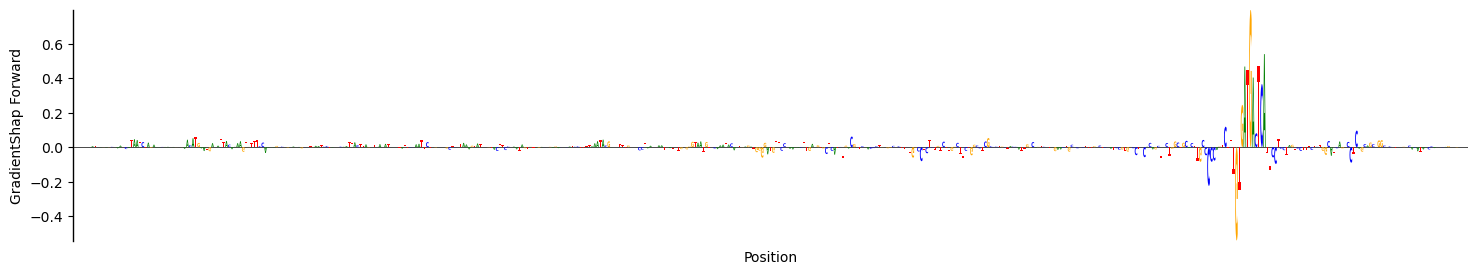

In [104]:
# Use the ouptut from above to highlight specific seqlets
pl.seq_track(
    sdata_test,
    seq_id=ids[top10[4]],
    attrs_key="GradientShap_attrs",
    ylab="GradientShap Forward",
    figsize=(18, 3),
    #highlights=[(387, 400)],
    highlight_colors = ["lightcyan"],
    #save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top1_with_color.pdf")
)

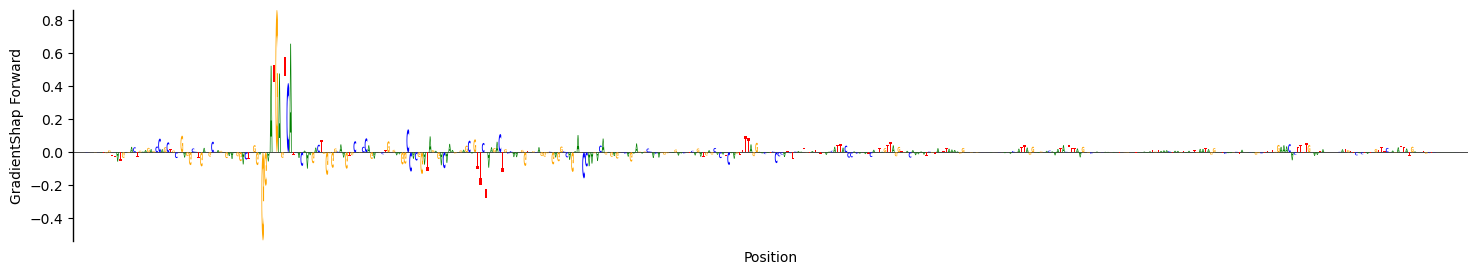

In [105]:
# Use the ouptut from above to highlight specific seqlets
pl.seq_track(
    sdata_test,
    seq_id=ids[top10[4]],
    attrs_key="GradientShap_attrs_rc",
    ylab="GradientShap Forward",
    figsize=(18, 3),
    #highlights=[(387, 400)],
    highlight_colors = ["lightcyan"],
    #save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top1_with_color.pdf")
)

## Filter viz (only for convnet)

In [13]:
layer_name = "arch.conv1d_tower.layers.1"
transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}

In [14]:
# Generate pfms from filters
interpret.generate_pfms_sdata(
    model,
    sdata_test,
    seq_key="ohe_seq",
    layer_name=layer_name,
    kernel_size=11,
    num_filters=10,
    num_seqlets=100,
    transforms=transforms,
)

Getting activations on batches of size 128:   0%|          | 0/503 [00:00<?, ?it/s]

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
sdata_test

<xarray.Dataset>
Dimensions:                                (_sequence: 64309, cov_sample: 1,
                                            _length: 500, length: 500, _ohe: 4,
                                            _arch.conv1d_tower.layers.1_10_filters: 10,
                                            _arch.conv1d_tower.layers.1_11_kernel_size: 11)
Coordinates:
  * cov_sample                             (cov_sample) object 'stam'
Dimensions without coordinates: _sequence, _length, length, _ohe,
                                _arch.conv1d_tower.layers.1_10_filters,
                                _arch.conv1d_tower.layers.1_11_kernel_size
Data variables: (12/15)
    chrom                                  (_sequence) object 'chr3' ... 'chr3'
    chromEnd                               (_sequence) int64 1394750 ... 1980...
    chromStart                             (_sequence) int64 1394250 ... 1980...
    cnn_trial_1_target_predictions         (_sequence) float32 -3.696 ... -5.524
    cov                                    (_sequence, cov_sample, _length) uint16 ...
    fcn_trial_1_target_predictions         (_sequence) float32 -3.299 ... -3.942
    ...                                     ...
    seq                                    (_sequence, _length) |S1 b'A' ... ...
    strand                                 (_sequence) object '+' '+' ... '+'
    target                                 (_sequence) uint8 0 0 0 0 ... 0 0 0 0
    train_test                             (_sequence) bool False ... False
    GradientShap_attrs                     (_sequence, _ohe, length) float32 ...
    arch.conv1d_tower.layers.1_pfms        (_arch.conv1d_tower.layers.1_10_filters, _arch.conv1d_tower.layers.1_11_kernel_size, _ohe) float32 ...
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

In [17]:
# Save all the filter pfms from above as meme format for submission to TomTom
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_key=f"{layer_name}_pfms", 
    axis_order=(f"_{layer_name}_10_filters", "_ohe", f"_{layer_name}_11_kernel_size"),
    output_dir=os.path.join(settings.output_dir, model_type),
    filename=f"best_model_{model_type}_filters.meme"
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/cnn
Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21/cnn/best_model_cnn_filters.meme


In [18]:
# Save the predictions and interpretations to zarr
sd.to_zarr(sdata_test, os.path.join(settings.output_dir, model_type, f"test_predictions_and_interpretations.zarr"), load_first=True, mode="w")

## In silico interpretation

In [21]:
# Prep feature from meme file
meme = md.read_meme(os.path.join(settings.dataset_dir, "MA0491.1.meme"))
motif = meme.motifs["MA0491.1"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus

In [22]:
zero_pfm = np.zeros(pfm.shape)
rand_pfm = sp.ohe(sp.random_seq(pfm.shape[0]), alphabet=sp.ALPHABETS["DNA"])
shuffled_pfm = sp.ohe(sp.k_shuffle(consensus, k=1).tobytes().decode(), alphabet=sp.ALPHABETS["DNA"])
zero_pfm.shape, rand_pfm.shape, shuffled_pfm.shape

((11, 4), (11, 4), (11, 4))

In [23]:
random_seqs = sp.ohe(sp.random_seqs(10, 500), alphabet=sp.ALPHABETS["DNA"]).transpose(0, 2, 1)

In [24]:
import xarray as xr

In [27]:
xr.Dataset?

Init signature:
xr.Dataset(
    data_vars: 'Mapping[Any, Any] | None' = None,
    coords: 'Mapping[Any, Any] | None' = None,
    attrs: 'Mapping[Any, Any] | None' = None,
) -> 'None'
Docstring:     
A multi-dimensional, in memory, array database.

A dataset resembles an in-memory representation of a NetCDF file,
and consists of variables, coordinates and attributes which
together form a self describing dataset.

Dataset implements the mapping interface with keys given by variable
names and values given by DataArray objects for each variable name.

One dimensional variables with name equal to their dimension are
index coordinates used for label based indexing.

To load data from a file or file-like object, use the `open_dataset`
function.

Parameters
----------
data_vars : dict-like, optional
    A mapping from variable names to :py:class:`~xarray.DataArray`
    objects, :py:class:`~xarray.Variable` objects or to tuples of
    the form ``(dims, data[, attrs])`` which can be used as
    

In [37]:
sdata_implant = xr.Dataset({"ohe_seq": xr.DataArray(random_seqs, dims=("_sequence", "_ohe", "length"))})
from eugene import preprocess as pp

In [38]:
pp.make_unique_ids_sdata(sdata_implant, id_var="name")

In [42]:
# Slide the TATA motif across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=pfm,
    feature_name=feat_name,
    encoding="onehot",
    store_key=f"slide_{feat_name}",
)

# Slide a random seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=rand_pfm,
    feature_name="random",
    encoding="onehot",
    store_key=f"slide_random",
)

# Slide a zero ohe seq across the sequences 
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=zero_pfm,
    feature_name="zero",
    encoding="onehot",
    store_key=f"slide_zero",
)

# Slide a TATA shuffled ohe seq across the sequences
interpret.positional_gia_sdata(
    model,
    sdata_implant,
    seq_key="ohe_seq",
    id_key="name",
    feature=shuffled_pfm,
    feature_name="shuffled",
    encoding="onehot",
    store_key=f"slide_shuffled",
)   

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
orig_preds = model.predict(torch.tensor(sdata_implant["ohe_seq"].values, dtype=torch.float32).to(model.device)).detach().cpu().numpy()

Predicting on batches: 0it [00:00, ?it/s]

In [65]:
np.min(sdata_implant[["slide_JUND", "slide_random", "slide_zero", "slide_shuffled"]])

<xarray.Dataset>
Dimensions:         ()
Data variables:
    slide_JUND      float64 -4.505
    slide_random    float64 -4.619
    slide_zero      float64 -4.773
    slide_shuffled  float64 -4.682

In [72]:
np.max(sdata_implant[["slide_JUND", "slide_random", "slide_zero", "slide_shuffled"]])

<xarray.Dataset>
Dimensions:         ()
Data variables:
    slide_JUND      float64 1.493
    slide_random    float64 -0.31
    slide_zero      float64 -0.8024
    slide_shuffled  float64 -1.634

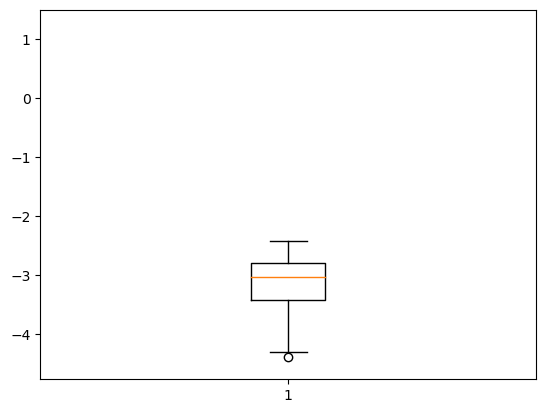

In [67]:
# Plot the original scores for the sequences
plt.boxplot(orig_preds)
plt.ylim(-4.773, 1.493)
plt.savefig(os.path.join(eu.settings.figure_dir, f"best_{model_type}_model_random_seq_scores.pdf"))

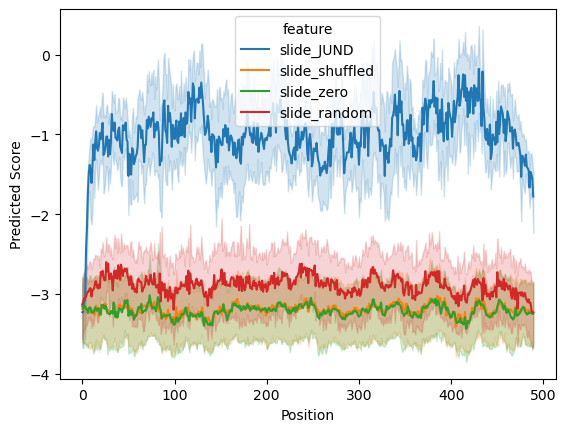

In [75]:
# Plot the implanted scores across positions
pl.positional_gia_plot(
    sdata_implant,
    keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    id_key="name",
    #save=os.path.join(eu.settings.figure_dir, f"best_{model_type}_model_feature_implant_jund.pdf")
)

In [73]:
# Save the evolved sequences  with the TATA implanted scores as well
sd.to_zarr(sdata_implant, os.path.join(settings.output_dir, f"jund_implant_feat_{model_type}.zarr"), load_first=True, mode="w")

---

# Scratch